In [36]:
import os
import json
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Config
MODEL = "openai/gpt-5"
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_URL = "https://openrouter.ai/api/v1/chat/completions"

if not OPENROUTER_API_KEY:
    raise ValueError("Set OPENROUTER_API_KEY environment variable")


In [37]:
# Load data
df = pd.read_csv("cleaned_resumes.csv")

# Get 20% stratified test set
_, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["experience_level"])
test_df = test_df.reset_index(drop=True)

print(f"Test set: {len(test_df)} samples")
print(test_df["experience_level"].value_counts())


Test set: 420 samples
experience_level
mid       140
junior    140
senior    140
Name: count, dtype: int64


In [ ]:
# Columns to include in the prompt (exclude target and personal info)
EXCLUDE_COLS = {"experience_level", "name", "email", "linkedin", "github", "summary_count", "total_experience_time", "last_experience_time", "last_experience_only"}

def build_resume_text(row):
    """Build resume text from row data."""
    parts = []
    for col in row.index:
        if col not in EXCLUDE_COLS:
            val = str(row[col]).strip()
            if val and val.lower() != "nan":
                parts.append(f"{col}: {val}")
    return "\n".join(parts)

def call_api(resume_text):
    """Call API and return the predicted label (junior/mid/senior)."""
    prompt = f"""You are classifying job candidates by seniority level.
Based on the resume below, respond with exactly ONE word: junior, mid, or senior.

{resume_text}

Your answer (one word only):"""
    
    payload = json.dumps({
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
        # "max_tokens": 16
    }).encode("utf-8")
    
    req = urllib.request.Request(
        OPENROUTER_URL,
        data=payload,
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        }
    )
    
    try:
        with urllib.request.urlopen(req, timeout=120) as resp:
            result = json.loads(resp.read().decode("utf-8"))
    except urllib.error.HTTPError as e:
        error_body = e.read().decode("utf-8")
        raise Exception(f"HTTP {e.code}: {error_body}")
    
    response = result["choices"][0]["message"]["content"].strip().lower()
    
    # Extract valid label
    if "junior" in response:
        return "junior"
    elif "mid" in response:
        return "mid"
    elif "senior" in response:
        return "senior"
    else:
        return "unknown"


In [39]:
# Run classification
y_true = []
y_pred = []

for idx, row in test_df.iterrows():
    true_label = row["experience_level"].strip().lower()
    resume_text = build_resume_text(row)
    
    try:
        pred_label = call_api(resume_text)
    except Exception as e:
        print(f"Row {idx} failed: {e}")
        pred_label = "unknown"
    
    y_true.append(true_label)
    y_pred.append(pred_label)
    
    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1}/{len(test_df)}")

print(f"\nDone! {len(y_pred)} predictions")


Processed 50/420
Processed 100/420
Processed 150/420
Processed 200/420
Processed 250/420
Processed 300/420
Processed 350/420
Processed 400/420

Done! 420 predictions


In [45]:
print(resume_text)

experience: Experience 1: Title: backend developer. Responsibilities: Ensured application responsiveness and seamless user experience. Performed software testing and resolved bugs efficiently. Utilized version control effectively in a team environment. Implemented RESTful APIs and microservices. Conducted code reviews and mentored junior developers.. Experience 2: Title: backend developer. Responsibilities: Conducted system monitoring and performance tuning. Conducted code reviews and mentored junior developers. Developed and maintained CI/CD pipelines. Managed cloud infrastructure and resource allocation.. Experience 3: Title: backend developer. Responsibilities: Managed cloud infrastructure and resource allocation. Ensured application responsiveness and seamless user experience. Collaborated with cross-functional teams to design new features..
projects: Project 1: Backend Developer Project. Description: Built scalable backend systems using Python and Django, enabling efficient data p

Accuracy: 0.4000 (40.00%)

Classification Report:
              precision    recall  f1-score   support

      junior     1.0000    0.1929    0.3234       140
         mid     0.0152    0.0071    0.0097       140
      senior     0.4281    1.0000    0.5996       140

    accuracy                         0.4000       420
   macro avg     0.4811    0.4000    0.3109       420
weighted avg     0.4811    0.4000    0.3109       420



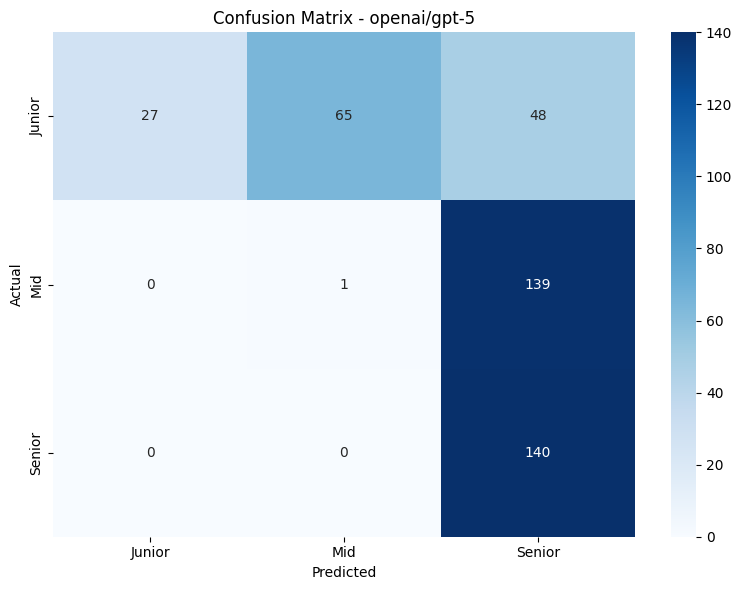

In [44]:
# Results
labels = ["junior", "mid", "senior"]

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=labels, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Junior', 'Mid', 'Senior'],
            yticklabels=['Junior', 'Mid', 'Senior'])
plt.title(f'Confusion Matrix - {MODEL}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
